In [1]:
from triqs.plot.mpl_interface import *
from triqs.gf import *

# change scale of all figures to make them bigger
import matplotlib as mpl
from h5 import *

import triqs.utility.mpi as mpi

from ctint_tutorial import Solver,Solver2
import numpy as np

Starting run with 1 MPI rank(s) at : 2022-05-28 17:43:28.519581


In [2]:
def fuse_eo(u):
    n = len(u)
    assert n%2==0
    m = n//2
    v = np.zeros(m,dtype=type(u[0]))
    for k in range(m-1):
        v[k] = u[2*k]+u[2*k+1]
    return v

In [200]:
ids = np.arange(1,dtype=int)

files = []
files2 = []

Ns = []
Ns2 = []

beta = []
U = []
delta = []
delta0 = []

for id in ids:
    files.append(f"data/{id}test_solver.h5")
    files2.append(f"data/{id}test_solver2.h5")

    with HDFArchive(files[id],'r') as A:
        Ns.append(A['N'])
        beta.append(A['beta'])
        U.append(A['U'])
        delta.append(A['delta'])
        delta0.append(A['delta0'])

    with HDFArchive(files2[id],'r') as B:
        Ns2.append(B['N'])
        assert beta[id] == B['beta']
        assert U[id] == B['U']
        assert delta[id] == B['delta']
        assert delta0[id] == B['delta0']

print(f"Ns\t= {Ns}")
print(f"Ns2\t= {Ns2}")
print(f"beta\t= {beta}")
print(f"U\t= {U}")
print(f"delta\t= {delta}")
print(f"delta0\t= {delta0}")

Ns	= [10]
Ns2	= [2]
beta	= [5]
U	= [6]
delta	= [0.1]
delta0	= [0.5]


## Histogram

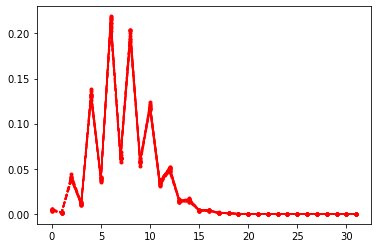

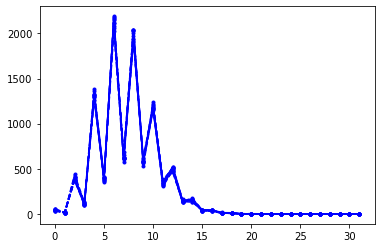

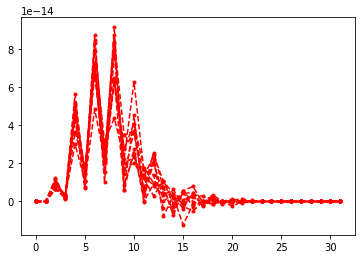

In [201]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_{i}'])
            k = np.arange(N)
            if True:
                plt.plot(k,A[f'hist_{i}'],'r.--')
            else:
                plt.plot(k,A[f'hist_{i}'],'r.')
        plt.show()

        for i in range(Ns[id]):
            N = len(A[f'hist_sign_{i}'])
            k = np.arange(N)
            #print(A[f'hist_sign_{i}'][0:2])
            #if A[f'hist_sign_{i}'][0] != 0:
            plt.plot(k,A[f'hist_sign_{i}'].real,'b.--')
        plt.show()

        for i in range(Ns[id]):
            N = len(A[f'hist_sign_{i}'])
            k = np.arange(N)
            #print(A[f'hist_sign_{i}'][0:2])
            plt.plot(k,A[f'hist_sign_{i}'].imag,'r.--')
        plt.show()

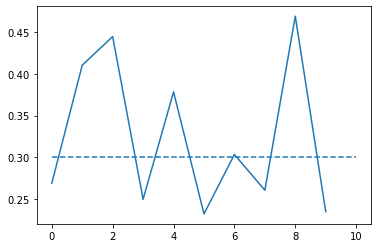

In [202]:
for id in ids:
    g = GfImFreq(beta=beta[id],indices=[0])
    mu = U[id]/2
    half_bandwidth = 1.0
    g << inverse(iOmega_n + mu - U[id]*delta0[id] - (half_bandwidth/2.0)**2 * SemiCircular(half_bandwidth) )
    n = g.density()[0,0].real
    k = np.arange(Ns[id])
    Z1 = np.zeros(Ns[id],dtype=complex)

    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            Z1[i] = A[f"hist_sign_{i}"][1]/A[f"hist_sign_{i}"][0]

    plt.plot(k,Z1.real)
    Z1_th = -U[id]*beta[id]*(n-delta0[id]+delta[id])*(n-delta0[id]-delta[id])
    plt.hlines(Z1_th,0,Ns[id],linestyles='--') #,colors='g'
    plt.show()

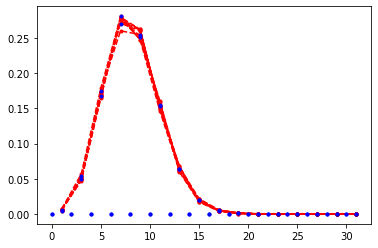

In [203]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_{i}'])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_{i}'][:N-N%2])
            plt.plot(k,h,'r.--')


    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            N = len(B[f'hist_{i}'])
            k = np.arange(N)
            plt.plot(k,B[f'hist_{i}'],'b.')

plt.show()

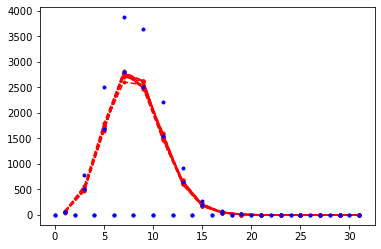

In [204]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_sign_{i}'])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_sign_{i}'][:N-N%2])
            plt.plot(k,h.real,'r.--')

        k0 = 1
        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_sign_{i}'])
                k = np.arange(N)
                if B[f'hist_sign_{i}'][k0] != 0 and A[f'hist_sign_{i}'][k0-1]+A[f'hist_sign_{i}'][k0] != 0:
                    h = B[f'hist_sign_{i}']/B[f'hist_sign_{i}'][k0] * (A[f'hist_sign_{i}'][k0]+A[f'hist_sign_{i}'][k0-1])
                    plt.plot(k,h.real,'b.')
                else:
                    print(f"invalid {i}")
    plt.show()

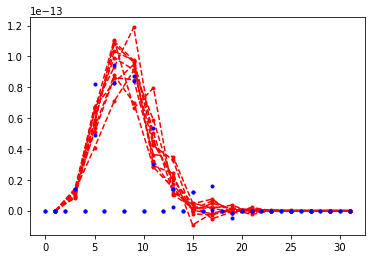

In [205]:
for id in ids:
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            N = len(A[f'hist_sign_{i}'])
            k = np.arange(N//2)*2+1
            h = fuse_eo(A[f'hist_sign_{i}'][:N-N%2])
            plt.plot(k,h.imag,'r.--')

        k0 = 1
        with HDFArchive(files2[id],'r') as B:
            for i in range(Ns2[id]):
                N = len(B[f'hist_sign_{i}'])
                k = np.arange(N)
                if B[f'hist_sign_{i}'][k0] != 0 and A[f'hist_sign_{i}'][k0-1]+A[f'hist_sign_{i}'][k0] != 0:
                    h = B[f'hist_sign_{i}']/B[f'hist_sign_{i}'][k0] * (A[f'hist_sign_{i}'][k0]+A[f'hist_sign_{i}'][k0-1])
                    plt.plot(k,h.imag,'b.')
                else:
                    print(f"invalid {i}")
    plt.show()

## Density

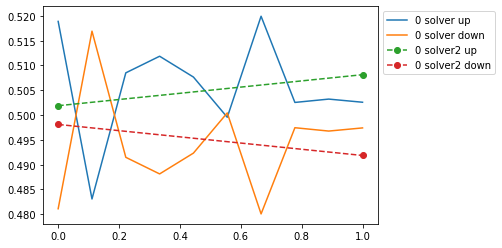

In [206]:
for id in ids:#[1:]:
    k = np.linspace(0,1,Ns[id])
    n = np.zeros((Ns[id],2),dtype=complex)
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            n[i] = A[f"n_{i}"]+delta0[id]
    plt.plot(k,n.real,label=[f"{id} solver up",f"{id} solver down"])

    k = np.linspace(0,1,Ns2[id])
    n2 = np.zeros((Ns2[id],2),dtype=complex)
    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            n2[i] = B[f"n_{i}"]+delta0[id]
    plt.plot(k,n2.real,'o--',label=[f"{id} solver2 up",f"{id} solver2 down"])

plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Double Occupancy

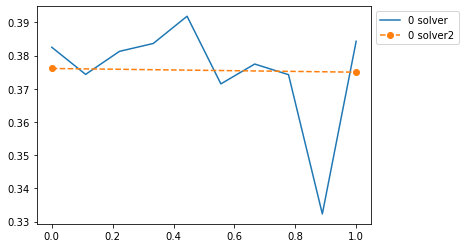

In [208]:
for id in ids:#[1:]:
    k = np.linspace(0,1,Ns[id])
    d = np.zeros(Ns[id],dtype=complex)
    with HDFArchive(files[id],'r') as A:
        for i in range(Ns[id]):
            d[i] = A[f"d_{i}"]+delta0[id]*(np.sum(A[f"n_{i}"]+delta0[id])+delta0[id]**2-delta[id]**2)
    plt.plot(k,d.real,label=f"{id} solver")

    k = np.linspace(0,1,Ns2[id])
    d2 = np.zeros(Ns2[id],dtype=complex)
    with HDFArchive(files2[id],'r') as B:
        for i in range(Ns2[id]):
            d2[i] = B[f"d_{i}"]+delta0[id]*(np.sum(B[f"n_{i}"]+delta0[id])+delta0[id]**2-delta[id]**2)
    plt.plot(k,d2.real,"o--",label=f"{id} solver2")

plt.legend(bbox_to_anchor=(1,1))
plt.show()

## GF

In [ ]:
Nom = 10 # # of Matsubara frequencies

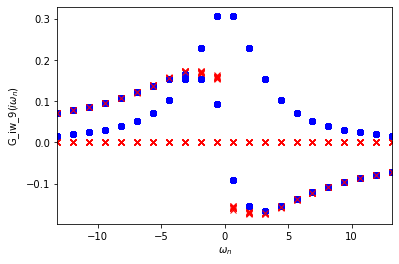

In [216]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G0_iw_{i}'], 'bo')
            oplot(A[f'G_iw_{i}'], 'rx')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

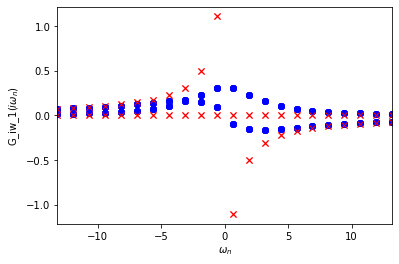

In [210]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files2[id],'r') as A:
        for i in range(A[f'N']):
            oplot(A[f'G0_iw_{i}'], 'bo')
            oplot(A[f'G_iw_{i}'], 'rx')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

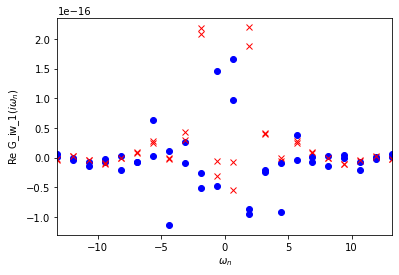

In [211]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        with HDFArchive(files2[id],'r') as B:
            for i in range(B[f'N']):
                oplot(A[f'G_iw_{i}'].real, 'bo')
                oplot(B[f'G_iw_{i}'].real, 'rx')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()

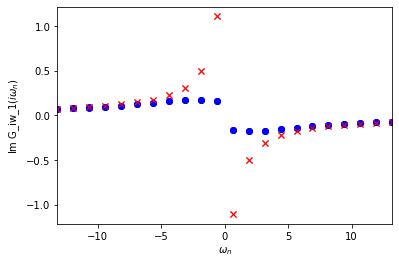

In [212]:
for id in ids:
    xm = (2*Nom+1)*np.pi/beta[id]
    with HDFArchive(files[id],'r') as A:
        with HDFArchive(files2[id],'r') as B:
            for i in range(B[f'N']):
                oplot(A[f'G_iw_{i}'].imag, 'bo')
                oplot(B[f'G_iw_{i}'].imag, 'rx')

    plt.xlim(-xm,xm)
    plt.legend().remove()
    plt.show()